In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.stats.diagnostic import linear_rainbow

In [2]:
data = pd.read_csv(r"C:\Users\babur\OneDrive\Desktop\DAI-101\A-2\tips (data for regression problem).csv")
print(data.head())
print(data.info())
print(data.describe())

   total_bill   tip     sex smoker  day    time  size
0       16.99  1.01  Female     No  Sun  Dinner     2
1       10.34  1.66    Male     No  Sun  Dinner     3
2       21.01  3.50    Male     No  Sun  Dinner     3
3       23.68  3.31    Male     No  Sun  Dinner     2
4       24.59  3.61  Female     No  Sun  Dinner     4
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244 entries, 0 to 243
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   total_bill  244 non-null    float64
 1   tip         244 non-null    float64
 2   sex         244 non-null    object 
 3   smoker      244 non-null    object 
 4   day         244 non-null    object 
 5   time        244 non-null    object 
 6   size        244 non-null    int64  
dtypes: float64(2), int64(1), object(4)
memory usage: 13.5+ KB
None
       total_bill         tip        size
count  244.000000  244.000000  244.000000
mean    19.785943    2.998279    2.569672
std      

,Model,MAE,MSE,R2
0,Linear Regression,0.708022,0.893920,0.554503
1,Ridge Regression,0.689720,0.876300,0.563284
2,Lasso Regression,0.666294,0.884100,0.559397
3,Decision Tree,1.060204,2.196876,-0.094843
4,Random Forest,0.696431,0.744714,0.628862
5,Support Vector Regression,0.661374,0.894009,0.554458
6,K-Nearest Neighbors,0.750694,1.003923,0.499681


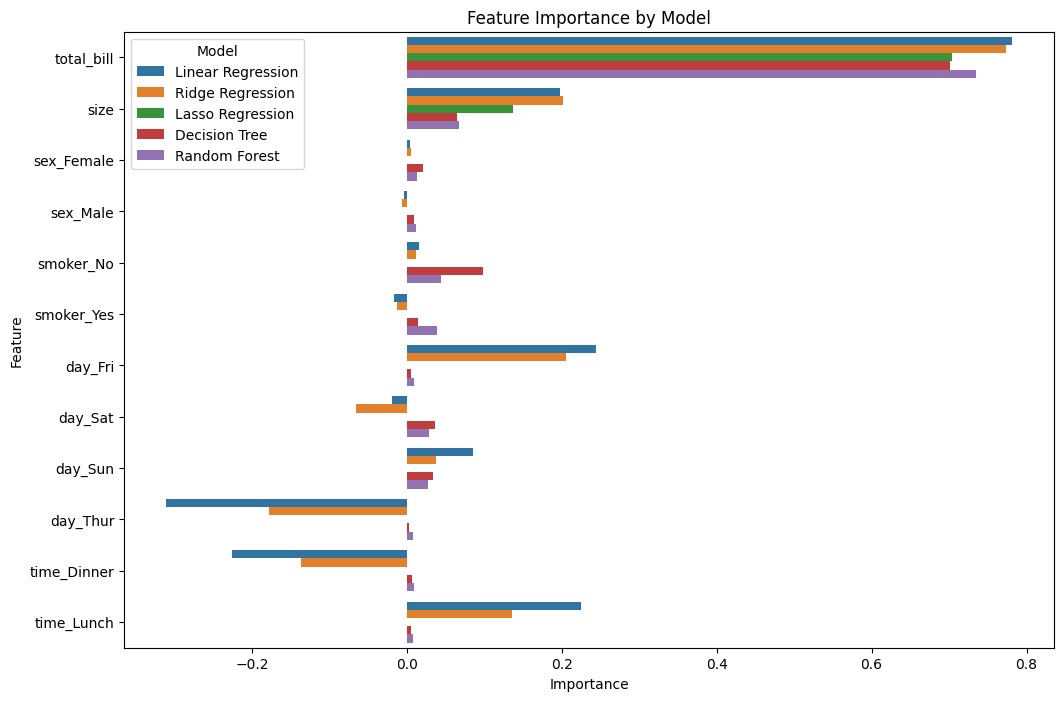

In [3]:
X = data.drop(columns=['tip'])
y = data['tip']

# Define preprocessing for numerical and categorical features
categorical_features = ['sex', 'smoker', 'day', 'time']
numerical_features = ['total_bill', 'size']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(), categorical_features)
    ])

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Initialize models
models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(alpha=1.0),
    "Lasso Regression": Lasso(alpha=0.1),
    "Decision Tree": DecisionTreeRegressor(random_state=0),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=0),
    "Support Vector Regression": SVR(kernel='linear', C=1.0, epsilon=0.1),
    "K-Nearest Neighbors": KNeighborsRegressor(n_neighbors=5)
}

# Initialize list to store model performance and feature importance data
model_performance = []
feature_importance_df = pd.DataFrame()

# Loop over models
for name, model in models.items():
    # Pipeline with preprocessing and model
    pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('model', model)])
    
    # Fit the model
    pipeline.fit(X_train, y_train)
    
    # Predictions
    y_pred = pipeline.predict(X_test)
    
    # Model evaluation
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    model_performance.append({"Model": name, "MAE": mae, "MSE": mse, "R2": r2})
    
    # Get feature importances or coefficients, if available
    if name in ["Linear Regression", "Ridge Regression", "Lasso Regression"]:
        # Coefficients for linear models
        coef = pipeline.named_steps['model'].coef_
        feature_names = numerical_features + list(pipeline.named_steps['preprocessor'].transformers_[1][1].get_feature_names_out(categorical_features))
        importance = pd.DataFrame({"Feature": feature_names, "Importance": coef, "Model": name})
        
    elif name in ["Decision Tree", "Random Forest"]:
        # Feature importances for tree-based models
        importances = pipeline.named_steps['model'].feature_importances_
        feature_names = numerical_features + list(pipeline.named_steps['preprocessor'].transformers_[1][1].get_feature_names_out(categorical_features))
        importance = pd.DataFrame({"Feature": feature_names, "Importance": importances, "Model": name})
        
    else:
        # SVR and KNN do not offer feature importances
        importance = pd.DataFrame({"Feature": [], "Importance": [], "Model": name})
    
    # Append importance data if available
    if not importance.empty:
        feature_importance_df = pd.concat([feature_importance_df, importance], axis=0)

# Convert performance list to DataFrame
performance_df = pd.DataFrame(model_performance)
display(performance_df)

# Plot feature importance for models that support it
plt.figure(figsize=(12, 8))
sns.barplot(data=feature_importance_df, x="Importance", y="Feature", hue="Model")
plt.title("Feature Importance by Model")
plt.show()

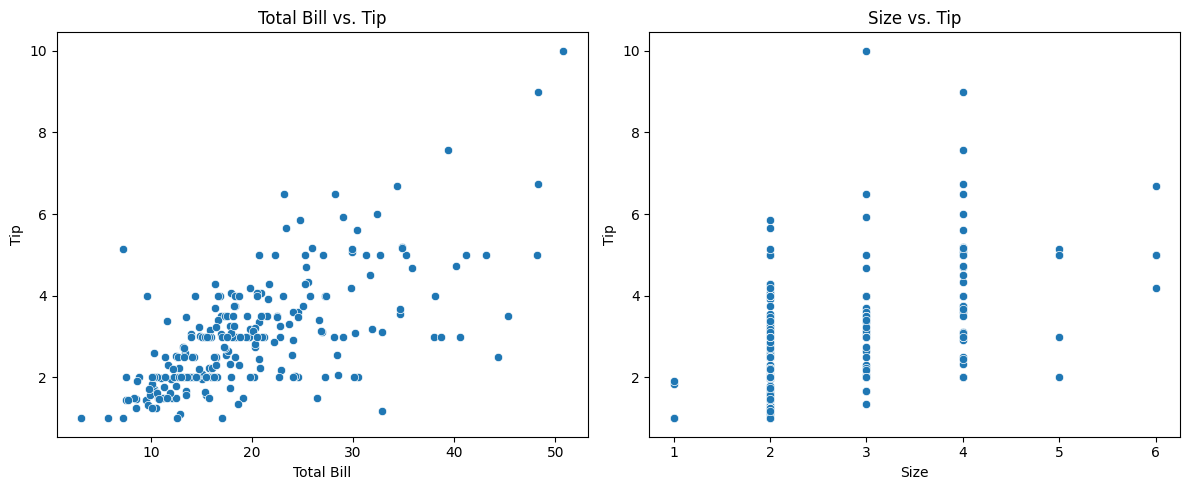

In [4]:
plt.figure(figsize=(12, 5))

# Scatter plot for total_bill vs. tip
plt.subplot(1, 2, 1)
sns.scatterplot(data=data, x='total_bill', y='tip')
plt.title('Total Bill vs. Tip')
plt.xlabel('Total Bill')
plt.ylabel('Tip')

# Scatter plot for size vs. tip
plt.subplot(1, 2, 2)
sns.scatterplot(data=data, x='size', y='tip')
plt.title('Size vs. Tip')
plt.xlabel('Size')
plt.ylabel('Tip')

plt.tight_layout()
plt.show()

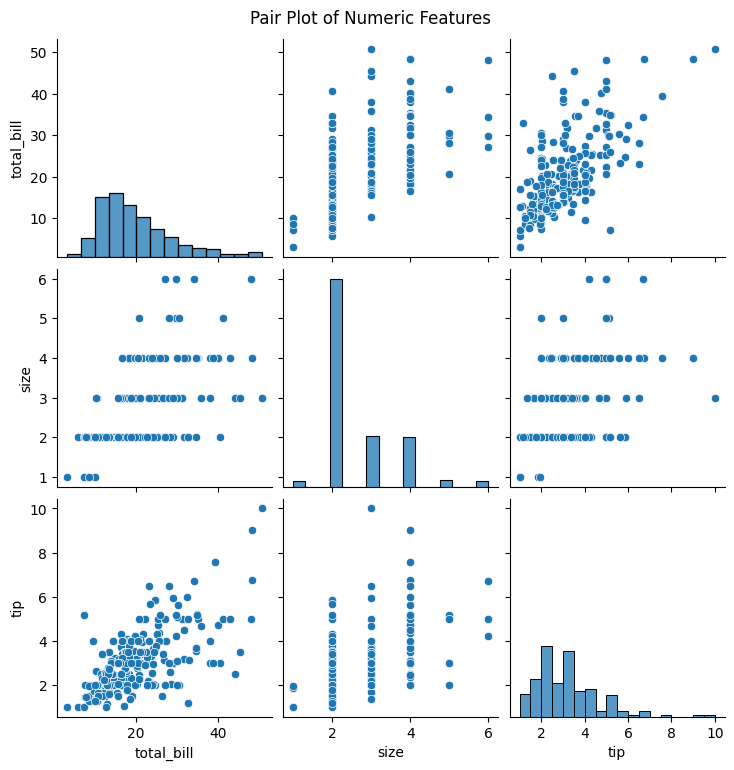

In [5]:
sns.pairplot(data[['total_bill', 'size', 'tip']])
plt.suptitle('Pair Plot of Numeric Features', y=1.02)  # Adjust title position
plt.show()

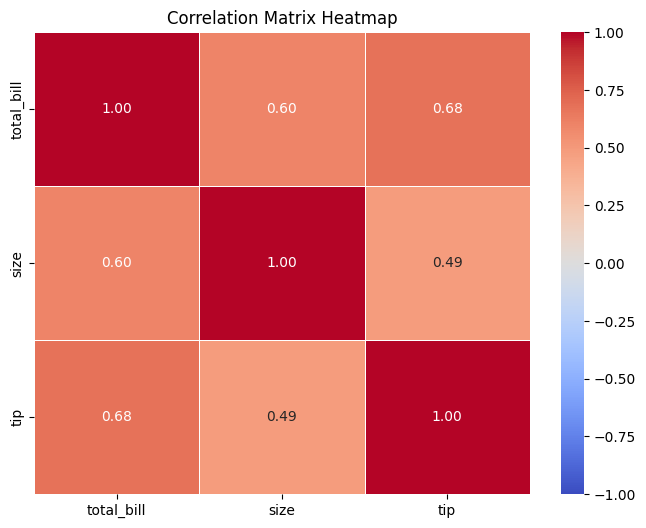

In [6]:
correlation_matrix = data[['total_bill', 'size', 'tip']].corr()

# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix Heatmap')
plt.show()

In [7]:
X = sm.add_constant(data[['total_bill', 'size']])
y = data['tip']

# Fit an Ordinary Least Squares (OLS) regression model
model = sm.OLS(y, X).fit()

# Perform the Rainbow Test
rainbow_statistic, rainbow_p_value = linear_rainbow(model)

# Display test results
print("Rainbow Test Statistic:", rainbow_statistic)
print("Rainbow Test p-value:", rainbow_p_value)

# Interpretation of results
if rainbow_p_value > 0.05:
    print("The Rainbow Test suggests that a linear model is appropriate (p-value > 0.05).")
else:
    print("The Rainbow Test suggests that the data may not follow a linear trend (p-value <= 0.05).")

Rainbow Test Statistic: 1.1902656646832817
Rainbow Test p-value: 0.17048935693447642
The Rainbow Test suggests that a linear model is appropriate (p-value > 0.05).


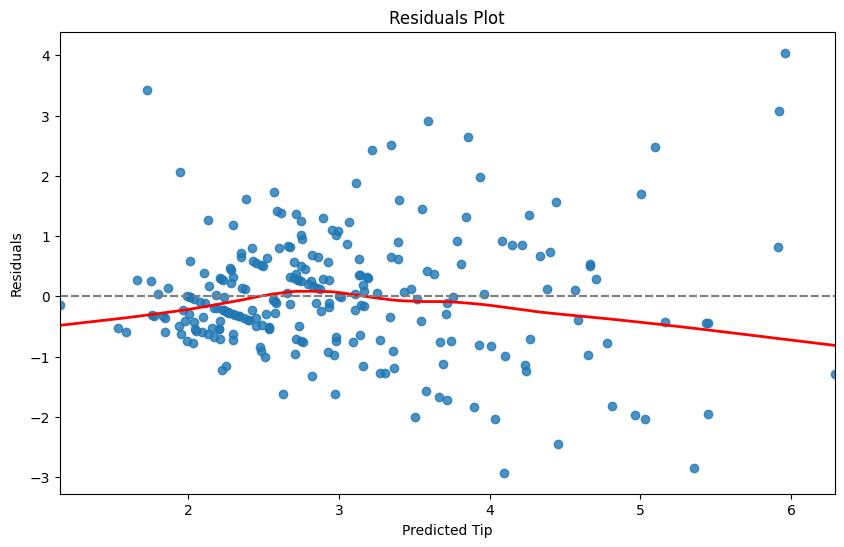

In [8]:
X = data[['total_bill', 'size']]
y = data['tip']

# Add a constant to predictors for the intercept
X = sm.add_constant(X)

# Fit an OLS regression model
model = sm.OLS(y, X).fit()

# Predict tip values
predictions = model.predict(X)

# Calculate residuals
residuals = y - predictions

# Plot the residuals
plt.figure(figsize=(10, 6))
sns.residplot(x=predictions, y=residuals, lowess=True, line_kws={'color': 'red', 'lw': 2})
plt.axhline(y=0, color='gray', linestyle='--')
plt.xlabel('Predicted Tip')
plt.ylabel('Residuals')
plt.title('Residuals Plot')
plt.show()

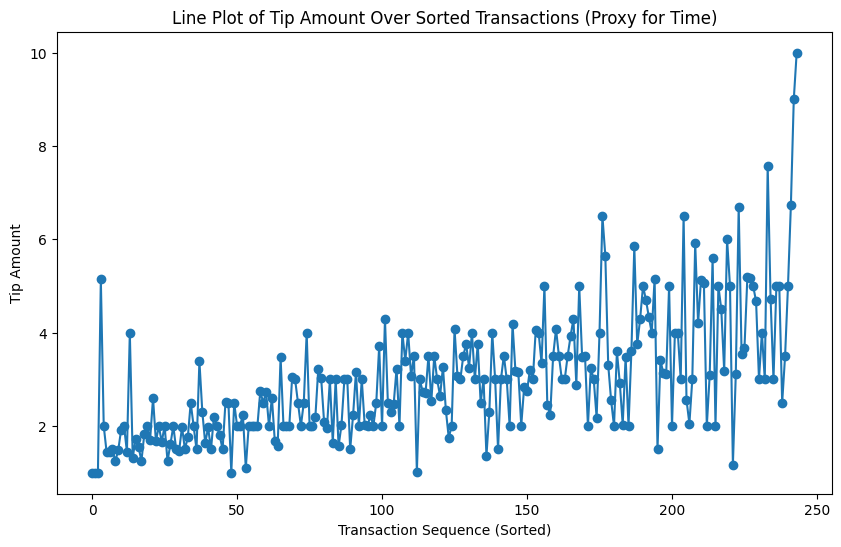

In [9]:
data_sorted = data.sort_values(by='total_bill').reset_index(drop=True)

# Plotting 'tip' over the sorted data index as a proxy for "time"
plt.figure(figsize=(10, 6))
plt.plot(data_sorted.index, data_sorted['tip'], marker='o', linestyle='-')
plt.title('Line Plot of Tip Amount Over Sorted Transactions (Proxy for Time)')
plt.xlabel('Transaction Sequence (Sorted)')
plt.ylabel('Tip Amount')
plt.show()